In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline  
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
df_cluster = pd.read_pickle('clustered_dataframe.pkl')

#### NUMBER OF DONORS & DONATIONS IN EACH CLUSTER

In [5]:
## number of donors in each cluster
donor_count_cl = df_cluster.groupby('cluster_id')['_donor_acctid'].nunique()
print('Number of Donors in Each Cluster')
print(donor_count_cl)

Number of Donors in Each Cluster
cluster_id
0     335192
1    1318236
2     133328
Name: _donor_acctid, dtype: int64


In [6]:
## number of donations in each cluster
cluster_count=df_cluster.groupby('cluster_id').size()
cluster_count.columns=['cluster_id', 'count']
print('Number of Donations from Each Cluster')
print(cluster_count)

Number of Donations from Each Cluster
cluster_id
0     760003
1    1318236
2    2541228
dtype: int64


Text(0.5, 1.0, 'Number of Donations from Each Cluster')

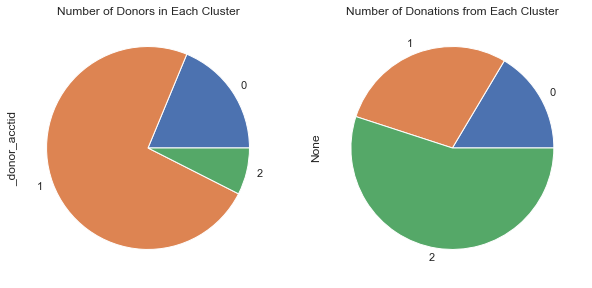

In [8]:
sns.set()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
donor_count_cl.plot(kind='pie', ax=ax0)
cluster_count.plot(kind='pie', ax=ax1)
ax0.set_title('Number of Donors in Each Cluster')
ax1.set_title('Number of Donations from Each Cluster')

Even though there is only a small portion of donors in cluster 2, they contributed to a large percentage of total donations in terms of number of donations.

#### DONOR BEHAVIOR

Donation Count

In [13]:
## donation frequency
donation_count = df_cluster.groupby('_donor_acctid').agg({'cluster_id': 'max', 
                                                          '_donor_acctid': 'count'}).reindex_axis(['cluster_id', 
                                                                                                   '_donor_acctid'], axis=1)
donation_count.columns=['cluster_id', 'donation_frequency']
donation_count.head(3)

,cluster_id,donation_frequency
_donor_acctid,,
0000023f507999464aa2b78875b7e5d6,1,1
00000ce845c00cbf0686c992fc369df4,1,1
00002eb25d60a09c318efbd0797bffb5,0,2


In [14]:
mean_frequency = donation_count.groupby('cluster_id')['donation_frequency'].agg(['min', 'max', 'mean', 'median'])
mean_frequency = mean_frequency.reset_index()
#mean_frequency.columns = ['clusters', 'min', 'max', 'mean']
mean_frequency.head()

,cluster_id,min,max,mean,median
0,0,1,41,2.267366,2
1,1,1,1,1.000000,1
2,2,1,117096,19.059972,6


(0, 50)

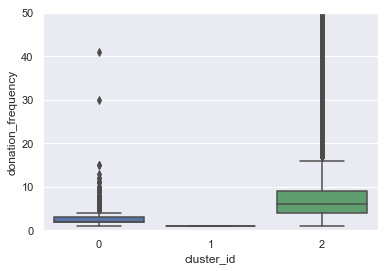

In [23]:
sns.boxplot(x='cluster_id', y='donation_frequency', data=donation_count)
plt.ylim(0,50)

All the donors in cluster 1 are single-time donors. Donors in cluster 2 on average donated 19 times each person. This is the cluster with the highest donation retention. Majority of donors in cluster 0 donated between 2-4 times as shown below.

In [16]:
cluster_0 = donation_count[donation_count['cluster_id']==0]['donation_frequency']
cluster_0.value_counts().head(5)

2    250698
3     80465
4      3369
5       446
6       123
Name: donation_frequency, dtype: int64

Donation Amount

In [24]:
donation_amt = df_cluster.groupby('cluster_id')['donation_total'].agg(['count', 'sum','mean', 'median', 'std'])
donation_amt

,count,sum,mean,median,std
cluster_id,,,,,
0,760003,41844544.0,55.058392,25.0,181.583496
1,1318236,62884352.0,47.703407,25.0,203.597839
2,2541228,258144128.0,101.582436,25.0,341.185211


In [25]:
large_donors = df_cluster[df_cluster['donation_total']>10000]
large_donors['cluster_id'].value_counts()

2    218
1     16
0     14
Name: cluster_id, dtype: int64

In terms of donation amount, all the groups have a median donation of `$`25 dollars, while donors in cluster 2 have the highest average donation amount. When we filter for the donations that are higher than `$`10,000, most of them are from cluster 2. We can also visualize the distribution of a sample of the donations from the below chart. 

In [29]:
indiv_donor_amt = df_cluster.groupby('_donor_acctid').agg({'cluster_id': 'max', 
                                                           'donation_total': 'mean'}).reindex_axis(['cluster_id',
                                                                                                   'donation_total'], axis=1)
indiv_donor_amt.columns=['cluster_id','average_donation']
donation_ct_amt = donation_count.merge(indiv_donor_amt, left_index=True, right_index=True)

In [30]:
dca_sample = donation_ct_amt.sample(frac=0.0005)

(0, 550)

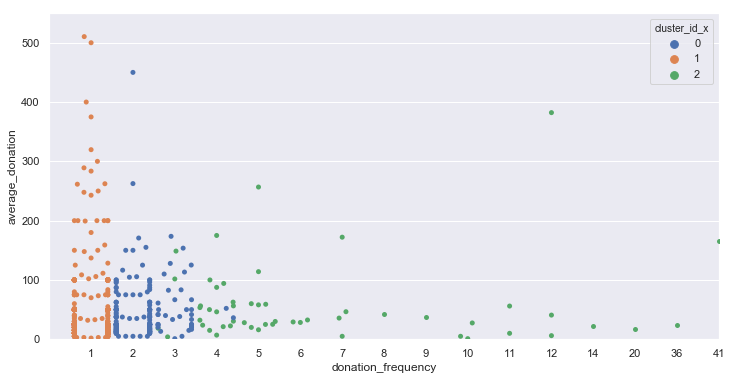

In [31]:
plt.figure(figsize=(12,6))
sns.swarmplot(x='donation_frequency', y='average_donation', data=dca_sample, hue='cluster_id_x')
plt.xlim(-1, 15)
plt.ylim(0,550)

#### DONORS AND STATES

Donors by States

We will visualize the distribution of donors on a map. To speed up the loading of the map, only a sample of the data points are shown on the visualization. 

In [32]:
import plotly
plotly.tools.set_credentials_file(username='ireneyao', api_key='yYWRMhq6Xyj7Trq94xjG')

In [33]:
df_sample = df_cluster.sample(frac=0.0005)
scl = [ [0,"rgb(255, 153, 51)"],[0.5,"rgb(160, 160, 160)"],[1,"rgb(153, 204, 255)"] ]
data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sample['school_longitude'],
        lat = df_sample['school_latitude'],
        #locations = df_sample['donor_state'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = df_sample['cluster_id'].min(),
            color = df_sample['cluster_id'],
            cmax = df_sample['cluster_id'].max(),
            colorbar=dict(
                title="Clusters"
            )
        ))]

In [67]:
layout = dict(
        title = 'Donations in US Schools by Donor Clusters',
        colorbar = False,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

plotly.offline.init_notebook_mode(connected=True)
fig = dict( data=data, layout=layout )
plotly.offline.iplot(fig, validate=False)

From reading the map, we can see that donors from different clusters are spreaded out across the country with concentration on the east coast and California and Washington states on the west coast. 

Donation Counts by States

In [37]:
donor_state_grp = df_cluster.groupby(['donor_state', 'cluster_id'])['_donor_acctid'].count()
donor_state_grp = donor_state_grp.unstack('cluster_id')
donor_state_grp['sum'] = donor_state_grp.sum(axis=1)
donor_state_grp = donor_state_grp.sort_values('sum', ascending=False)#.reset_index()
donor_state_grp.head()

cluster_id,0,1,2,sum
donor_state,,,,
CA,151891,281104,436930,869925
NY,65784,93173,598236,757193
IL,43401,65698,230752,339851
FL,50571,81223,97263,229057
TX,39797,75401,90748,205946


In [38]:
donor_state_grp_plt = donor_state_grp.iloc[:, 0:3]
donor_state_grp_plt = donor_state_grp_plt.head(10)
donor_state_grp_plt.head(3)

cluster_id,0,1,2
donor_state,,,
CA,151891,281104,436930
NY,65784,93173,598236
IL,43401,65698,230752


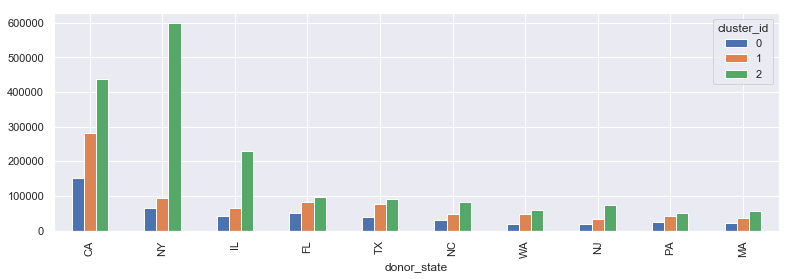

In [41]:
fig, ax = plt.subplots(figsize=(13, 4))
donor_state_grp_plt.plot(kind='bar', ax=ax)

California, New York, and Illinois have the most number of donations. New York has the largest proportion of donors from cluster 2.

Donation Amount by State

In [42]:
donation_by_state = df_cluster.groupby(['donor_state', 'cluster_id'])['donation_total'].sum()
donation_by_state = donation_by_state.unstack('cluster_id')
donation_by_state['sum'] = donation_by_state.sum(axis=1)
donation_by_state = donation_by_state.sort_values('sum', ascending=False).reset_index()
donation_by_state.head()

cluster_id,donor_state,0,1,2,sum
0,CA,8236811.00,11822394.00,63528524.0,83587728.0
1,NY,4167656.75,5206392.50,63360768.0,72734816.0
2,IL,2332286.00,3261335.25,15161704.0,20755324.0
3,TX,2457721.50,4060607.25,7033380.5,13551710.0
4,FL,2354676.75,3593194.50,6346402.5,12294274.0


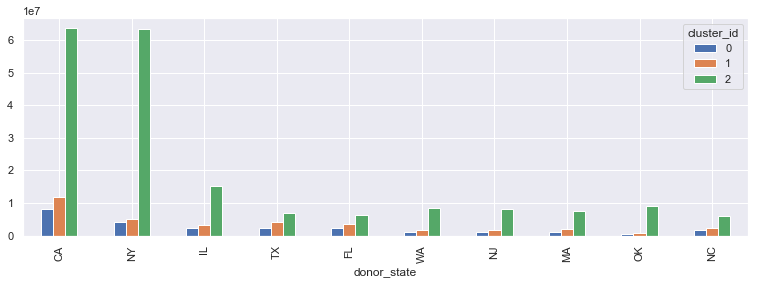

In [43]:
fig, ax = plt.subplots(figsize=(13, 4))
donation_by_state.iloc[0:10, 0:4].plot(x='donor_state', kind='bar', ax=ax)

California, New York, and Illinois also have the highest amount of donations among all US states. This was probably also driven by the large donations from donors in cluster 2.

#### DONATIONS vs. THANK YOU PACKETS

In [44]:
## thank_you_packet
thank_you = df_cluster.groupby(['cluster_id', 'thank_you_packet_mailed']).size()#.set_index('thank_you_packet_mailed')
thank_you = thank_you.unstack('thank_you_packet_mailed')
thank_you.columns.name=None
thank_you.columns = ['f', 't']

def cal_percent(row):
    return (row['t']/row['f'])

thank_you['perc'] = thank_you.apply(cal_percent, axis=1)
thank_you

,f,t,perc
cluster_id,,,
0,685139,74864,0.109268
1,1204026,114210,0.094857
2,2182113,359115,0.164572


According to the chart above, group 2 received the most percentage of thank you cards. That's probably why they are more motivated. The joinplot below also shows a positive correlation between number of thank you packets received and total number of donations for each donor. 

#### DONORS vs. TEACHER ACCOUNT

In [48]:
teacher_acct = df_cluster[['_donor_acctid', 'cluster_id', 'is_teacher_acct']].drop_duplicates()
teacher_count = teacher_acct.groupby(['cluster_id','is_teacher_acct']).size()
teacher_count = teacher_count.unstack('cluster_id')
teacher_count.columns.name=None
teacher_count.index = ['Not Teacher', 'Teacher']
teacher_count = teacher_count.div(teacher_count.sum())
#def cal_percent(row):
    #return (row['t']/(row['f']+row['t']))

#teacher_count['perc'] = teacher_count.apply(cal_percent, axis=1)

teacher_count = teacher_count.transpose()
teacher_count

,Not Teacher,Teacher
0,0.899810,0.100190
1,0.955708,0.044292
2,0.820225,0.179775


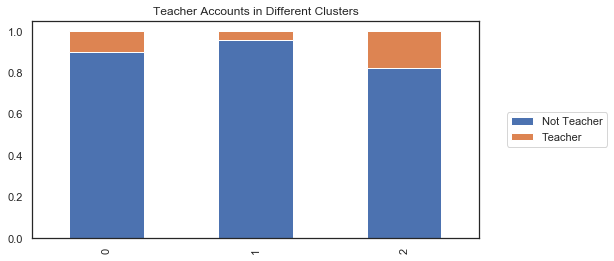

In [50]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,4))
teacher_count.plot(kind='bar', stacked=True, ax=ax, title='Teacher Accounts in Different Clusters')
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

Cluster 2 has the highest percentage of teacher account as donors, while clusters 1, which consists mostly single-time donors, has the lowest fraction of teacher account. 

In [51]:
teachers = df_cluster[df_cluster['is_teacher_acct']==1]
teacher_mean = teachers.groupby('_donor_acctid').size().mean()
print('On average, donors with a teacher account donated', round(teacher_mean, 2), 'times per person.')

On average, donors with a teacher account donated 5.73 times per person.


#### DONATIONS vs. GRADE LEVEL

In [52]:
df_grades = df_cluster.groupby(['grade_level', 'cluster_id']).size()
df_grades = df_grades.unstack('cluster_id')
df_grades

cluster_id,0,1,2
grade_level,,,
Grades 3-5,238401,410362,813886
Grades 6-8,129694,230596,412394
Grades 9-12,105344,194655,334871
Grades PreK-2,286537,482564,979995


Text(0, 0.5, '')

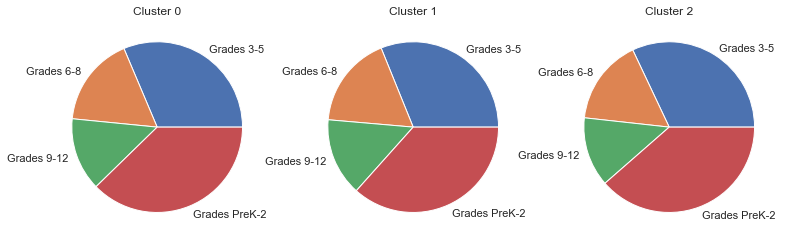

In [53]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(13,4))
df_grades[0].plot(kind='pie', ax=ax0,)
ax0.set_title('Cluster 0')
ax0.set_ylabel('')
df_grades[1].plot(kind='pie', ax=ax1)
ax1.set_title('Cluster 1')
ax1.set_ylabel('')
df_grades[2].plot(kind='pie', ax=ax2)
ax2.set_title('Cluster 2')
ax2.set_ylabel('')

The 3 clusters share similar pattern when donating in different grade levels. 

#### DONATIONS vs. POVERTY LEVEL

In [54]:
poverty = df_cluster.groupby(['cluster_id', 'poverty_level']).size()
poverty = poverty.unstack('cluster_id')
poverty

cluster_id,0,1,2
poverty_level,,,
high poverty,184073,341105,632787
highest poverty,421560,695126,1500583
low poverty,26982,48351,61213
moderate poverty,127388,233654,346645


In [56]:
poverty = poverty.div(poverty.sum())

Text(0.5, 0, 'Clusters')

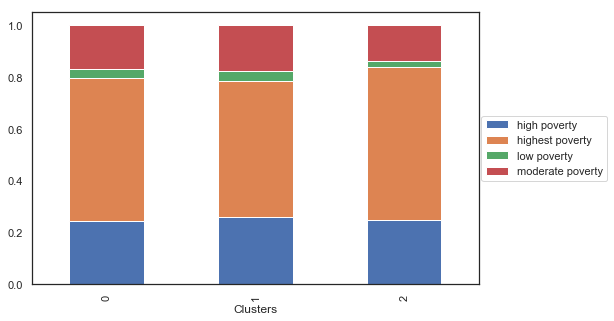

In [57]:
fig, ax = plt.subplots(figsize=(8,5))
poverty.T.plot(kind='bar', stacked=True, ax=ax)
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
ax.set_xlabel('Clusters')

As shown in the above graph, donors in cluster 2 made a slightly higher percentage of donations in the highest poverty category.

#### DONATIONS vs. PROJECT DONOR COUNT

Since most of the projects have a number of donors below 50, we will filter out the projects with large number of donors for the analysis. 

In [58]:
df_most_donor = df_cluster[df_cluster['num_donors']<50]

In [59]:
ta = df_most_donor.groupby(['cluster_id','num_donors']).size().unstack('cluster_id')
#ta['sum']=ta.sum(axis=1)
ta.head()

cluster_id,0,1,2
num_donors,,,
0,124,4,372
1,23669,18937,149933
2,38026,37505,224643
3,47085,54325,212750
4,52974,67807,201212


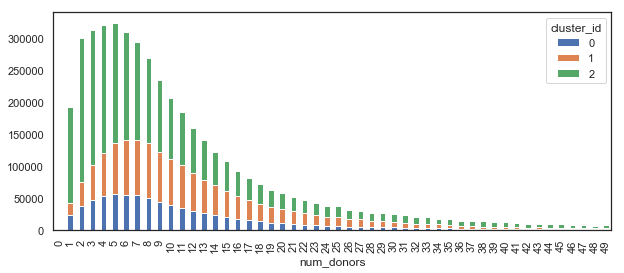

In [60]:
ta.plot(kind='bar', stacked=True, figsize=(10,4))

Projects with fewer donors (les than 10) received most of their fundings from cluster 2 donors. 

In [61]:
subject = df_cluster.groupby(['cluster_id', 'primary_focus_area']).size()#.set_index('thank_you_packet_mailed')
subject = subject.unstack('primary_focus_area')
subject

primary_focus_area,Applied Learning,Health & Sports,History & Civics,Literacy & Language,Math & Science,Music & The Arts,Special Needs
cluster_id,,,,,,,
0,47871,26751,31837,331709,193723,75610,52482
1,81019,49879,54093,571546,341889,125985,93781
2,169011,113149,110178,1045288,651638,282343,169520


In [64]:
subject = subject.div(subject.sum())

Text(0.5, 0, '')

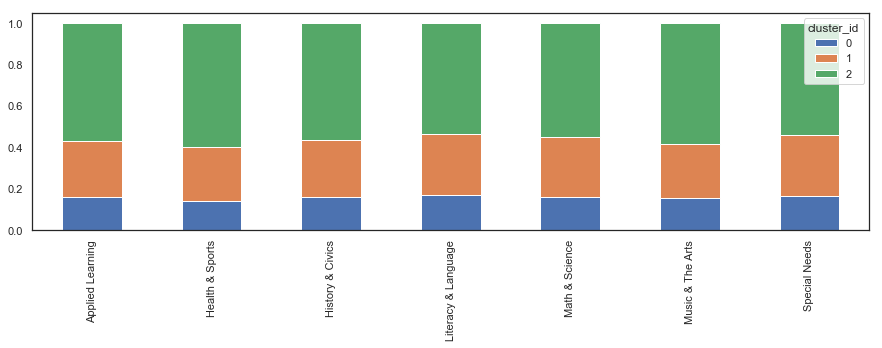

In [63]:
fig, ax = plt.subplots(figsize=(15,4))
subject.T.plot(kind='bar', ax=ax, stacked=True)
ax.set_xlabel('')

Donors from all 3 clusters are indifferent in choosing the project subject. Each subject has a similar proportion of donors from each clusters.

#### CONCLUSIONS FROM CLUSTERING

* The donors are clustered into 3 groups.
* Group 1 has the largest number of donors and Group 2 has the least number of donors.
* Even though Group 2 has the least number of donors, they contributed to the largest percentage of total number of donations.
* Group 1 are all single-time donors and Group 2 consists of many frequent donors.
* All the groups have a median donation of `$`25 dollars, while donors in Group 2 have the highest average donation amount. For all the donations exceeding `$`10,000, most of them are from Group 2 donors.
* Geographically, donors in all 3 groups scatter across US. There is no obvious pattern observed in terms of locations.
* New York has the largest proportions of donations from Group 2 compared to other states.
* Group 2 received the most percentage of thank you letters amongst all three groups. We also observed a slight positive correlation between number of thank you letters received and number of total donations.
* Cluster 2 has the highest percentage of teacher account as donors, while clusters 1, which consists mostly single-time donors, has the lowest fraction of teacher account. 
* Donors in Group 2 made a slightly higher percentage of donations in the highest poverty category.
* All 3 clusters exhibit similar donation behavior in terms of choosing projects from different grade levels, poverty levels, and project subject. 